In [1]:
import json
import math as m

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Build a vocab list from train dataset
def build_vocab_list(train_dataset):
    vocab_list = []
    for record in train_dataset:
        vocab_list.extend(record['headline'].split(" "))
    vocab_list = [word.lower() for word in list(set(vocab_list))]
    return vocab_list

In [3]:
#create count frequency of words on training data
def build_doc_freq_dict(train_dataset,categories):
    word_frequency_dict = {category:{vocab:0 for vocab in vocab_list} for category in categories}
    for record in train_dataset:
        for word in record['headline'].split(" "):
            word_frequency_dict[record['category']][word.lower()]+=1
    return word_frequency_dict


In [4]:
# seperate dataset by class 
def get_data_group_by_classes(dataset):
    seperated_category_dict = {category:[] for category in categories}
    for record in dataset:
        seperated_category_dict[record['category']].append(record)
    return seperated_category_dict

In [5]:
#checks if smoothing is needed
def is_smoothing_needed(text,word_dict,category):
    for word in text.split(" "):
        if word not in word_dict[category].keys():
            return True
    return False

# get probability of the text assuming conditional independence(naive bayes)         
def get_naive_probability(category,text,word_dict,grouped_classes_dict,dataset):
    text = text.lower()
    if category not in word_dict.keys():
        return
    total_word_cond_prob = 1
    smoothing_factor = 1
    smoothing_indicator = is_smoothing_needed(text,word_dict,category)
    for word in text.split(" "):
        if not smoothing_indicator:
            total_word_cond_prob *= (word_dict[category][word]/len(word_dict[category]))
        else:
            total_word_cond_prob *= (1/(len(word_dict[category])+smoothing_factor*len(word_dict[category]))) # Smoothing technique
    class_probability = (len(grouped_classes_dict[category])/len(dataset))
    return total_word_cond_prob * class_probability
       

In [6]:
#get the predicted class given text belong to
def get_predicted_class(categories,str_to_predict,word_frequency_dict,group_classes_dict,train_dataset):
    greatest_prob = 0
    predicted_category = ''
    for category in categories:
        total_word_cond_prob = 1
        prob_of_category_contains_headline =  get_naive_probability(category,str_to_predict,word_frequency_dict,group_classes_dict,train_dataset)
        if prob_of_category_contains_headline > greatest_prob:
            greatest_prob = prob_of_category_contains_headline
            predicted_category = category
        #print(f'''prob_of_category_contains_headline {category} is {prob_of_category_contains_headline}''')
    return predicted_category

In [7]:
 #calculate the accuracy of the classifier over given dataset:
def get_accuracy(dataset,categories,word_frequency_dict,group_classes_dict):
    correct_predicted = 0
    for record in dataset: 
        predicted_category = get_predicted_class(categories,record['headline'],word_frequency_dict,group_classes_dict,dataset)
        if predicted_category == record['category']:
            correct_predicted+=1
    return correct_predicted/len(dataset)

In [8]:
# Load the original dataset. 
dataset = []
categories = []
with open('data/News_Category_Dataset_v2.json') as data:
    for line_num,record in enumerate(data,start=0):
        dataset.append(json.loads(record))
        if dataset[line_num]['category'] not in categories:
            categories.append(dataset[line_num]['category'])
no_of_records = len(dataset)
print(f""" Number of records in the dataset: {no_of_records}""")
print(f""" Number of different categories in the dataset: {len(categories)}""")


 Number of records in the dataset: 200853
 Number of different categories in the dataset: 41


In [9]:
#Peek into the dataset
df = pd.DataFrame(dataset)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


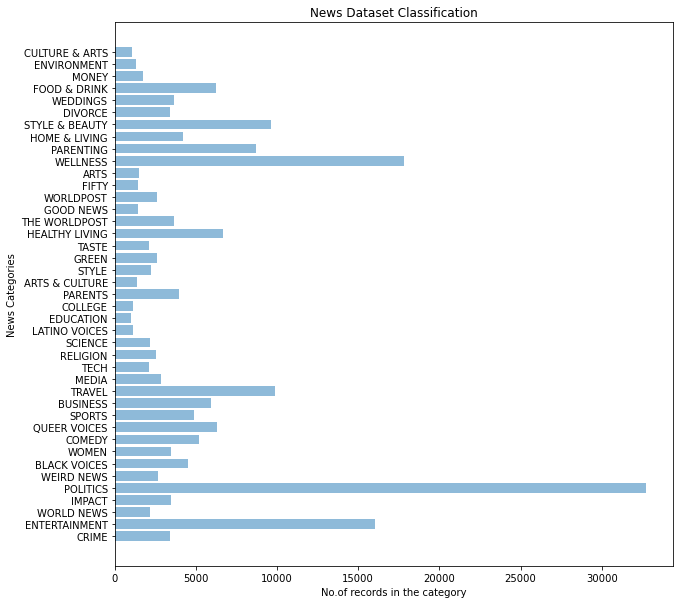

In [10]:
#Divide data in
all_group_category_records = get_data_group_by_classes(dataset)

# plot the data distribution of all news categories
all_news_categories = df.loc[:,'category'].unique()
lengths = []
for category in all_news_categories:
    lengths.append(len(all_group_category_records[category]))

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(all_news_categories,lengths, alpha=0.5)
ax.set_ylabel("News Categories")
ax.set_xlabel('No.of records in the category')
ax.set_title('News Dataset Classification')
plt.show()

In [11]:
#Divide the dataset into train and test data
k_fold =5
for i in range(k_fold):
    train_dataset,test_dataset = train_test_split(dataset,test_size=0.1)
    #print(f""" Number of records in the training dataset: {len(train_dataset)}""")
    #print(f""" Number of records in the test dataset: {len(test_dataset)}""")
    #Group all records with their respective category
    group_classes_dict = get_data_group_by_classes(train_dataset)
    vocab_list = build_vocab_list(train_dataset)
    word_frequency_dict = build_doc_freq_dict(train_dataset,categories)
    test_accuracy = get_accuracy(test_dataset,categories,word_frequency_dict,group_classes_dict)
    print(f'''Iteration:{i+1} Accuracy of the Naive Baye's Classifier over test dataset is {round(test_accuracy*100,2)}%''')

Iteration:1 Accuracy of the Naive Baye's Classifier over test dataset is 27.9%
Iteration:2 Accuracy of the Naive Baye's Classifier over test dataset is 27.99%
Iteration:3 Accuracy of the Naive Baye's Classifier over test dataset is 27.58%
Iteration:4 Accuracy of the Naive Baye's Classifier over test dataset is 27.81%
Iteration:5 Accuracy of the Naive Baye's Classifier over test dataset is 27.3%


In [12]:

#train_accuracy = get_accuracy(train_dataset,categories,word_frequency_dict,group_classes_dict)
#print(f'''Accuracy of the Naive Baye's Classifier over train dataset is {round(train_accuracy*100,2)}%''')
#sorted(word_frequency_dict["CRIME"].items(),key=lambda x: x[1], reverse=True)[25:100]